## link to my [repo](https://github.com/BR4GR/gbsv-challenges)

Modul [gbsv](https://www.fhnw.ch/de/studium/module/9470696) FHNW

## Part 1: Correlation in Signals

Overarching Task: Choose a country and theme all the MC tasks to this county. The use cases, problem statements, signals and images should be related to your country of choice. It can be the same country as in MC1, but you may also choose a different one.   

<h3 id="day-1">1: Exploring the Audio Landscape</h3>
Day 1 Task:

Suitable for your country: Define a use case to recognize whether a 1D signal contains recurring patterns. Find a suitable 1D signal (audio, time series, vital signs, ...) that contains recurring patterns to apply auto-correlation in the following days. 

Implementation:

first all needed imports are made and the signal is loaded and inspected

In [1]:
import time
import cv2 as cv
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sounddevice as sd

from scipy.io.wavfile import write
from scipy.signal import correlate, find_peaks
from scipy.fftpack import fft

from IPython.display import Markdown, Audio
from rich import print


In [2]:
audio, sample_rate = librosa.load("sound/bell.wav")
print(f"this is what the audio looks like. {audio}")
print(f"The dimension: {audio.shape}")
print(f"audio min: {np.max(audio)} and audio max: {np.min(audio)}")

display(Markdown(f"**ring the Bell**"), metadata={"tags": "audio"})
display(Audio(audio, rate=sample_rate))

this is what the audio looks like. [2.6749703e-35 8.3550063e-35 1.1725352e-34 ... 6.8832678e-04 7.8442483e-04
 0.0000000e+00]

The dimension: (1641260,)

audio min: 0.8644417524337769 and audio max: -0.8645315766334534

**ring the Bell**

The chosen use case is to estimate the weight/size of a Swiss cowbell based on its frequency characteristics using auto-correlation. Cowbells produce distinct resonant frequencies determined by their size, material, and weight. Identifying recurring patterns in their acoustic signal can help derive these physical properties. i chose this sound because cowbells are an iconic symbol of Swiss craftsmanship and tradition, and we can always hear them on our hiking trips on weekends. The objective of this experiment is to demonstrate whether auto-correlation can reliably detect these recurring patterns and link them to the bell’s weight. The chosen signal is a recording of a Swiss cowbell.

<h3 id="day-2">2: Defining the Experiment Objectives</h3>
Day 2 Task:

Analyze the recurring patterns within your 1D signal using auto-correlation.

Implementation:

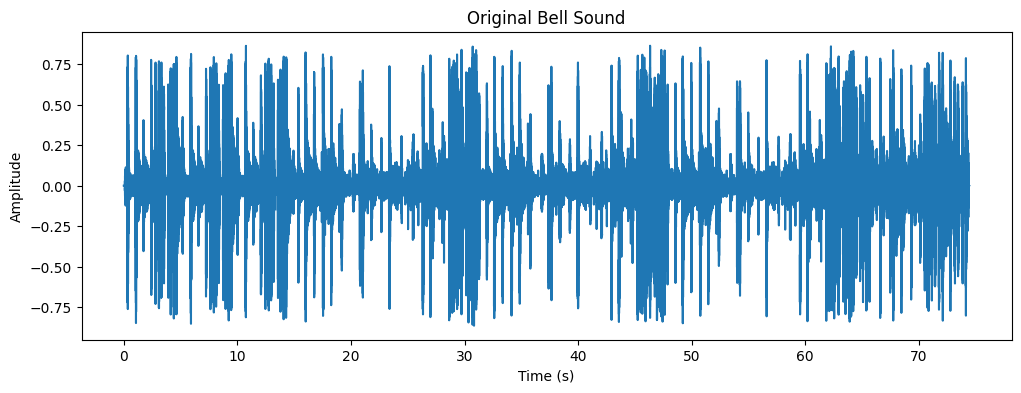

In [3]:
times = np.arange(0, len(audio)) / sample_rate
plt.figure(figsize=(12, 4))
plt.plot(times, audio)
plt.title("Original Bell Sound")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

I will analyze the signal in the time domain, the autocorrelation, and the frequency spectrum for two cases:
1. one full ring of a cowbell
2. only the later part of the ringing sound

This helps determine how the initial strike influences the periodicity and dominant frequencies.

**this is the ringing, with the initial strike**

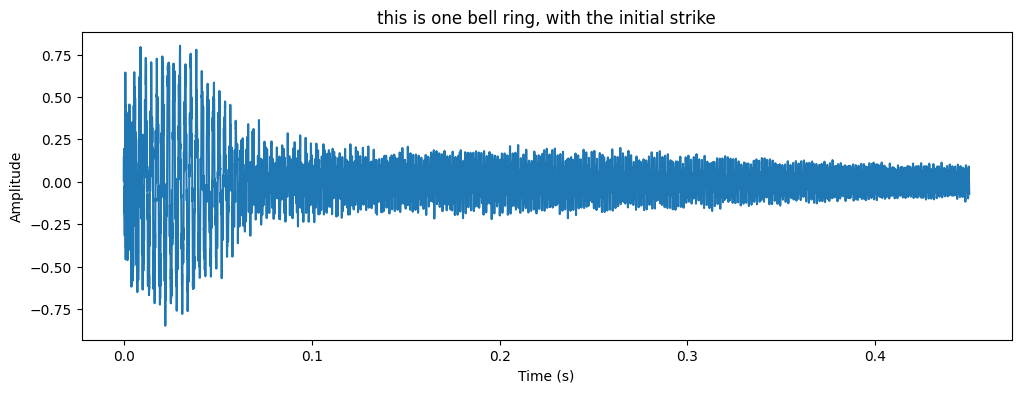

**this is only the ringing, without the initial strike**

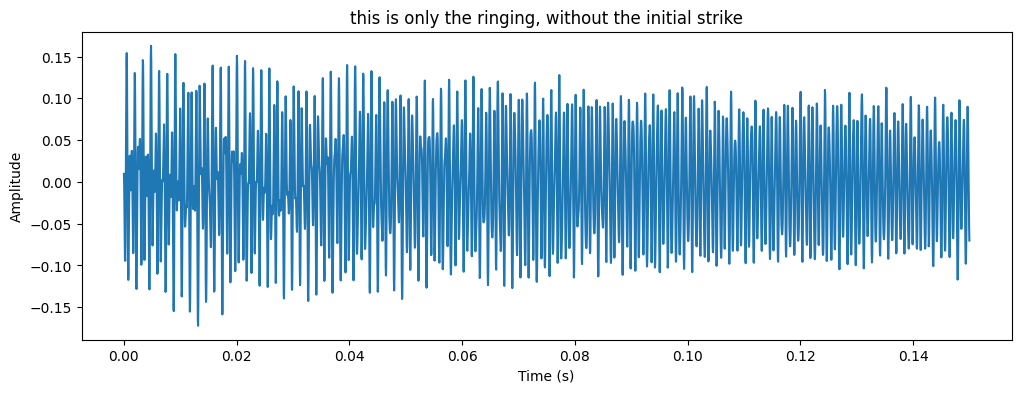

In [4]:
def trim_signal(signal, sample_rate, start_time, end_time):
    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)
    signal = signal[start_sample:end_sample]
    return  signal

signal_hit = trim_signal(audio, sample_rate, 1.05, 1.5)
write('sound/bell_with_hit.wav', sample_rate, signal_hit)

display(Markdown(f"**this is the ringing, with the initial strike**"))
display(Audio(signal_hit, rate=sample_rate))
times = np.arange(0, len(signal_hit)) / sample_rate
plt.figure(figsize=(12, 4))
plt.plot(times, signal_hit)
plt.title("this is one bell ring, with the initial strike")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


signal = trim_signal(audio, sample_rate, 1.35, 1.5)
write('sound/bell_no_hit.wav', sample_rate, signal)

display(Markdown(f"**this is only the ringing, without the initial strike**"))
display(Audio(signal, rate=sample_rate))
times = np.arange(0, len(signal)) / sample_rate
plt.figure(figsize=(12, 4))
plt.plot(times, signal)
plt.title("this is only the ringing, without the initial strike")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Ringing without hit Dominant Frequencies (Hz): [1379.79141475 2099.68258767]

KPIs for Ringing without hit: {'Mean': np.float32(-0.0001495729), 'Std Dev': np.float32(0.06533235), 'Variance': 
np.float32(0.004268316)}

Ringing with hit Dominant Frequencies (Hz): [ 328.87231684  666.63307467 1379.93046458 2095.44996473 2999.84883604]

KPIs for Ringing with hit: {'Mean': np.float32(-6.990738e-05), 'Std Dev': np.float32(0.15481316), 'Variance': 
np.float32(0.023967113)}

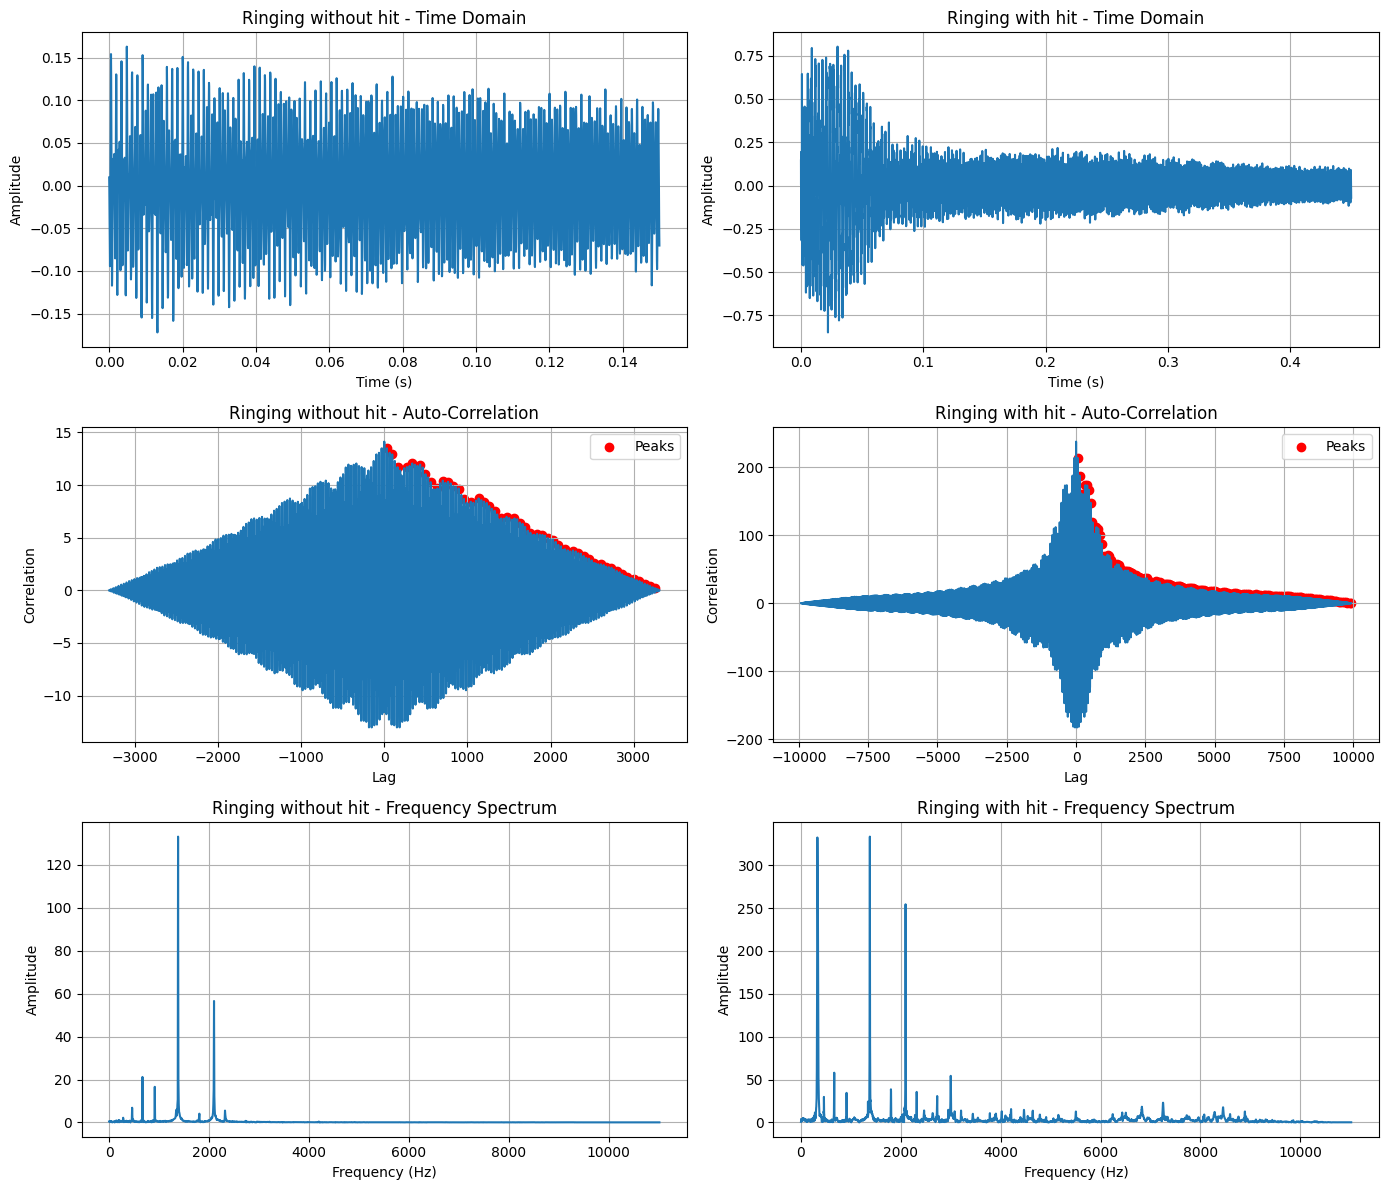

In [5]:
def compute_autocorrelation(signal):
    autocorr = correlate(signal, signal, mode='full')
    lags = np.arange(-len(signal) + 1, len(signal))
    return lags, autocorr

def calculate_kpis(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    return {"Mean": mean, "Std Dev": std, "Variance": var}

def compute_fft(signal, sample_rate):
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/sample_rate)
    fft_values = np.abs(fft(signal))[:N//2]
    return freqs[:N//2], fft_values


def plot_signal_analysis(signal1, signal2=None, sample_rate=None, labels=("Signal 1", "Signal 2")):

    signals = [signal1] if signal2 is None else [signal1, signal2]
    num_signals = len(signals)

    fig, axes = plt.subplots(3, num_signals, figsize=(7 * num_signals, 12))
    axes = axes if num_signals > 1 else [axes]

    for idx, signal in enumerate(signals):
        # Time Domain
        times = np.arange(len(signal)) / sample_rate
        axes[0][idx].plot(times, signal)
        axes[0][idx].set_title(f"{labels[idx]} - Time Domain")
        axes[0][idx].set_xlabel("Time (s)")
        axes[0][idx].set_ylabel("Amplitude")
        axes[0][idx].grid()

        # Auto-Correlation
        lags, autocorr = compute_autocorrelation(signal)
        peaks, _ = find_peaks(autocorr[len(autocorr)//2:], distance=50)
        peak_lags = lags[len(autocorr)//2:][peaks]
        axes[1][idx].plot(lags, autocorr)
        axes[1][idx].scatter(peak_lags, autocorr[len(autocorr)//2:][peaks], color='red', label='Peaks')
        axes[1][idx].set_title(f"{labels[idx]} - Auto-Correlation")
        axes[1][idx].set_xlabel("Lag")
        axes[1][idx].set_ylabel("Correlation")
        axes[1][idx].legend()
        axes[1][idx].grid()

        # Frequency Spectrum (FFT)
        freqs, fft_values = compute_fft(signal, sample_rate)
        axes[2][idx].plot(freqs, fft_values)
        axes[2][idx].set_title(f"{labels[idx]} - Frequency Spectrum")
        axes[2][idx].set_xlabel("Frequency (Hz)")
        axes[2][idx].set_ylabel("Amplitude")
        axes[2][idx].grid()

        # Identify peaks in the FFT values
        peaks, properties = find_peaks(fft_values, height=40)
        dominant_frequencies = freqs[peaks]

        # Display the frequencies
        print(f"{labels[idx]} Dominant Frequencies (Hz):", dominant_frequencies)

        # KPIs
        kpis = calculate_kpis(signal)
        print(f"KPIs for {labels[idx]}: {kpis}")

    plt.tight_layout()
    plt.show()


plot_signal_analysis(signal1=signal, signal2=signal_hit, sample_rate=sample_rate, labels=("Ringing without hit", "Ringing with hit"))


The signal with the initial hit demonstrates a sharper amplitude decay and additional low-frequency content, which is evident in the frequency spectrum where lower frequencies dominate the early part of the signal. The autocorrelation plot for the signal without the hit displays a smoother and more consistent decay, highlighting stronger periodicity and indicating that the ringing alone is more stable. This conclusion is supported by the calculated KPIs: the signal without the hit has a lower variance (0.0043 compared to 0.0239) and standard deviation (0.065 compared to 0.154), which indicate more predictable and stable oscillations. In contrast, the initial strike introduces transient energy and broadens the frequency spectrum, adding harmonics but reducing the overall stability of the periodic pattern, as reflected in the less uniform autocorrelation decay.

with the next plots i will focuse on zoomed-in regions of the ringing signal, comparing the raw signal to aligned sine waves of the dominant frequencies extracted from the FFT. This demonstrates how well these frequencies represent the periodic structure of the signal.

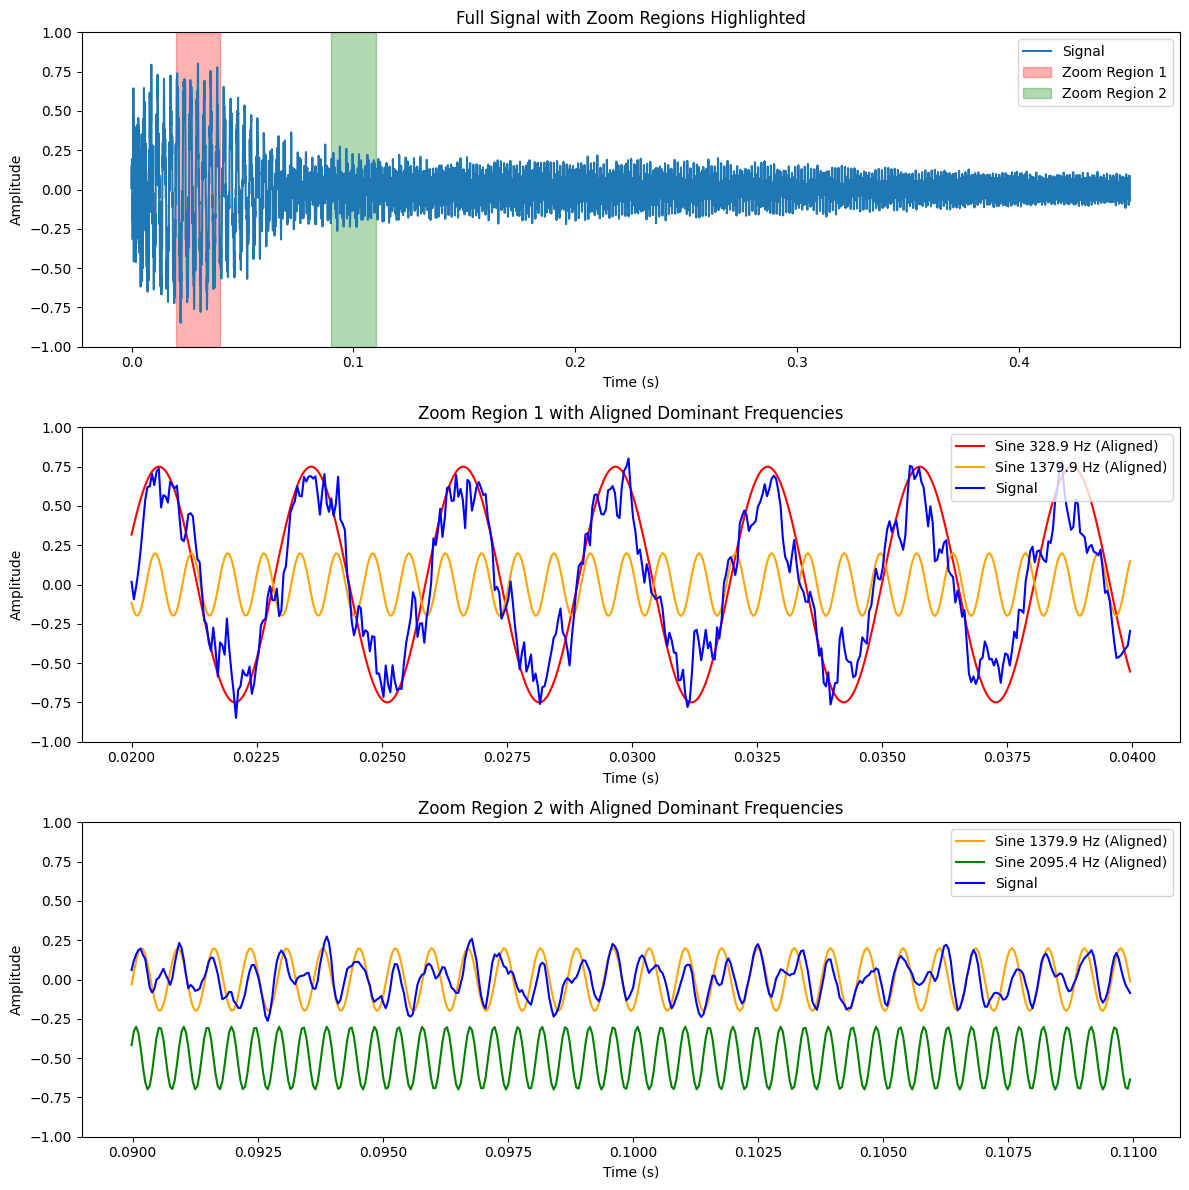

In [6]:
zoom_stage1_start, zoom_stage1_end = 0.02, 0.04 
zoom_stage2_start, zoom_stage2_end = 0.09, 0.11

times = np.arange(0, len(signal_hit)) / sample_rate

zoom_times_stage1 = times[int(zoom_stage1_start * sample_rate):int(zoom_stage1_end * sample_rate)]
zoom_signal_stage1 = signal_hit[int(zoom_stage1_start * sample_rate):int(zoom_stage1_end * sample_rate)]

zoom_times_stage2 = times[int(zoom_stage2_start * sample_rate):int(zoom_stage2_end * sample_rate)]
zoom_signal_stage2 = signal_hit[int(zoom_stage2_start * sample_rate):int(zoom_stage2_end * sample_rate)]

dominant_frequencies = [328.87231684, 1379.93046458, 2095.44996473]


def calculate_phase_offset(signal, sine_wave):
    correlation = correlate(signal, sine_wave, mode='full')
    lag = np.argmax(correlation) - len(sine_wave) + 1
    return lag

def generate_aligned_sine_wave(frequency, time, signal, amplitude=0.2):
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)
    lag = calculate_phase_offset(signal, sine_wave)
    aligned_sine_wave = amplitude * np.sin(2 * np.pi * frequency * (time - lag / sample_rate))
    return aligned_sine_wave

# Stage 2: Zoom Region 1
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(times, signal_hit, label="Signal")
plt.axvspan(zoom_stage1_start, zoom_stage1_end, color='red', alpha=0.3, label="Zoom Region 1")
plt.axvspan(zoom_stage2_start, zoom_stage2_end, color='green', alpha=0.3, label="Zoom Region 2")
plt.title("Full Signal with Zoom Regions Highlighted")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1, 1)
plt.legend()

plt.subplot(3, 1, 2)
aligned_sine_wave = generate_aligned_sine_wave(
    dominant_frequencies[0], zoom_times_stage1[:len(zoom_signal_stage1)], zoom_signal_stage1, 0.75
)
plt.plot(zoom_times_stage1, aligned_sine_wave, color='red', label=f"Sine {dominant_frequencies[0]:.1f} Hz (Aligned)")
aligned_sine_wave = generate_aligned_sine_wave(
    dominant_frequencies[1], zoom_times_stage1[:len(zoom_signal_stage1)], zoom_signal_stage1
)
plt.plot(zoom_times_stage1, aligned_sine_wave, color='orange', label=f"Sine {dominant_frequencies[1]:.1f} Hz (Aligned)")
plt.plot(zoom_times_stage1, zoom_signal_stage1, color='blue', label="Signal")
plt.title("Zoom Region 1 with Aligned Dominant Frequencies")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1, 1)
plt.legend()

# Stage 3: Zoom Region 2
plt.subplot(3, 1, 3)
aligned_sine_wave = generate_aligned_sine_wave(
    dominant_frequencies[1], zoom_times_stage2[:len(zoom_signal_stage2)], zoom_signal_stage2
)
plt.plot(zoom_times_stage2, aligned_sine_wave, color='orange', label=f"Sine {dominant_frequencies[1]:.1f} Hz (Aligned)")

aligned_sine_wave = generate_aligned_sine_wave(
    dominant_frequencies[2], zoom_times_stage2[:len(zoom_signal_stage2)], zoom_signal_stage2
)
plt.plot(zoom_times_stage2, aligned_sine_wave-0.5, color='green', label=f"Sine {dominant_frequencies[2]:.1f} Hz (Aligned)")
plt.plot(zoom_times_stage2, zoom_signal_stage2, color='blue', label="Signal")
plt.title("Zoom Region 2 with Aligned Dominant Frequencies")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1, 1)
plt.legend()

plt.tight_layout()
plt.show()

Observation:
In the first zoomed region, the sine wave at 328.9 Hz closely follows the signal's overall oscillations, showing its dominance in the lower-frequency range. This can only be observed right after the initial hit and fades the fastest. In the second zoomed region, the sine wave at 1380 Hz captures finer details, confirming its contribution to the higher-frequency components. These aligned sine waves visually highlight the signal's harmonic structure. Note that 1380 and 2095 Hz Frequencies are alredy present in the beginning but fade much slower. The 2095 Hz frequencie was plotted below the other ones to prevent overcrouding of the plot, but is is still interesting to observe its contribution.

<h3 id="day-3">3: Detecting Patterns</h3>
Day 3 Task:

Can the periodicity of your pattern be visualized via an auto-correlogram? Visualize the results appropriately. Observe, interpret and discuss in 2-3 sentences.

Implementation:

i believe most of the groundwork was done yesterday. Today, the focus will be on generating Auto-Korrelogramms specifically for the zoomed-in sections of the signal. Given the zoomed focus, we expect the correlation to be significantly higher in these regions.


Background: What is a Correlogram?
> In time series analysis, a plot of the sample autocorrelations \(r_h\) against time lags \(h\) is called an **autocorrelogram**.  
> If cross-correlation is plotted instead, the result is referred to as a **cross-correlogram**.  
> Autocorrelograms are particularly useful in identifying repeating patterns or periodicity within a signal.  
>  
> Source: [Wikipedia - Correlogram](https://en.wikipedia.org/wiki/Correlogram)


Zoom Region 1 KPIs:
{'Mean': np.float32(0.020076977), 'Std Dev': np.float32(0.43640673), 'Variance': np.float32(0.19045085)}

Zoom Region 2 KPIs:
{'Mean': np.float32(0.0046018558), 'Std Dev': np.float32(0.11034681), 'Variance': np.float32(0.012176419)}

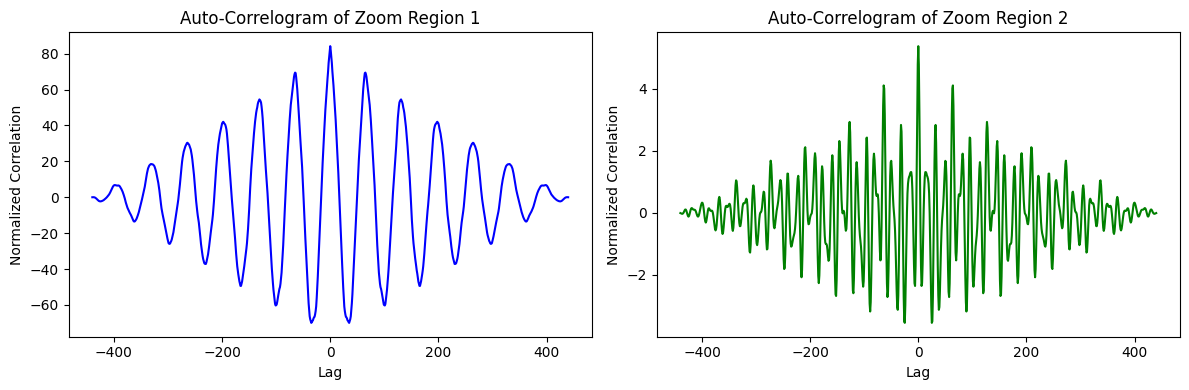

In [7]:
lags1, autocorr1 = compute_autocorrelation(zoom_signal_stage1)
peaks, _ = find_peaks(autocorr1[len(autocorr1)//2:], distance=50)
peak_lags = lags1[len(autocorr1)//2:][peaks]
stage1_kpis = calculate_kpis(zoom_signal_stage1)
print("Zoom Region 1 KPIs:", stage1_kpis)

lags2, autocorr2 = compute_autocorrelation(zoom_signal_stage2)
peaks, _ = find_peaks(autocorr2[len(autocorr2)//2:], distance=50)
peak_lags = lags2[len(autocorr2)//2:][peaks]
stage2_kpis = calculate_kpis(zoom_signal_stage2)
print("Zoom Region 2 KPIs:", stage2_kpis)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(lags1, autocorr1, color='blue')
plt.title(f"Auto-Correlogram of Zoom Region 1")
plt.xlabel("Lag")
plt.ylabel("Normalized Correlation")

plt.subplot(1, 2, 2)
plt.plot(lags2, autocorr2, color='green')
plt.title(f"Auto-Correlogram of Zoom Region 2")
plt.xlabel("Lag")
plt.ylabel("Normalized Correlation")

plt.tight_layout()
plt.show()

Zoom Region 1 shows prominent peaks in the autocorrelation at regular intervals, reflecting a strong and stable periodicity, which aligns well with the dominant 328.9 Hz frequency. This is further supported by higher KPIs like the standard deviation (0.436) and variance (0.190), which indicate stronger oscillatory behavior. In contrast, Zoom Region 2 exhibits less pronounced peaks and more irregular correlations, suggesting weaker periodicity likely caused by higher-frequency harmonics, as seen in the lower standard deviation (0.110) and variance (0.012).  These findings are relevant to the use case because the periodicity detected shows that auto-correlation can reliably identify recurring patterns in the bell's acoustic signal.

<h3 id="day-4">4: Discussion</h3>
Day 4 Task:

Discuss your choice of method and parameters as well as the results in approx. 150 words.

Implementation:

Switzerland’s iconic church bells serve as a rich source for studying acoustic properties due to their historical significance and precise craftsmanship. In this analysis, the methods and parameters were chosen to explore the ringing patterns of a bell and their connection to its physical properties, like weight and size. Auto-correlation was selected to uncover periodicities within the signal, as it is particularly suited to identifying repeating structures. Two zoom regions of the signal were examined: one focusing on the early, stable ringing (dominated by a single frequency) and another capturing the later, more complex decay with harmonics. The choice of parameters, such as zoom window lengths, was optimized to highlight different characteristics of the bell’s oscillations while maintaining clarity in the visualizations. 
Observing dominant frequencies like 328.9 Hz, 1380 Hz and 2095.4 Hz via FFT one can also observe the fast disapearing of the 328 Hz frequencie.
Their correspondence to auto-correlation peaks supported the hypothesis that periodicity diminishes as the signal decays. This method provides a practical framework for understanding acoustic signatures of bells, offering insights into their inner workings.

<h3 id="day-5">5: Choosing an Interesting Snippet</h3>
Day 5 Task:

Define a use case to find a piece of your signal again. Now cut out an interesting piece of your signal. Why did you choose this piece? What goal do you want to pursue by cutting it out? Should this piece only be found once or several times? Explain in a few sentences.

Imlementation:

For this task, I selected a slightly larger snippet from the same location as the previously extracted `zoom_signal_stage1`. This snippet represents a characteristic portion of the bell's ringing, slightly after the initial impact and a stable oscillatory phase. 

I chose this snippet because it is representative of the bell's acoustic signature, but only lasts a fraction of a whole ring, making it suitable for the use case of detecting and counting occurrences of the bell ring in the original 1-minute 14-second audio file. This way i should be able to demonstrate how the snippet's unique frequency and amplitude patterns can be leveraged to identify and quantify repeated bell rings across the entire recording. 

The objective of the experiment is to validate whether this snippet can be detected multiple times in the original signal using methods like cross-correlation, showcasing its applicability in acoustic pattern recognition tasks.

The plot below highlights the chosen snippet (marked in red) within one full bell ring, showing how it encapsulates the core characteristics of the signal. 

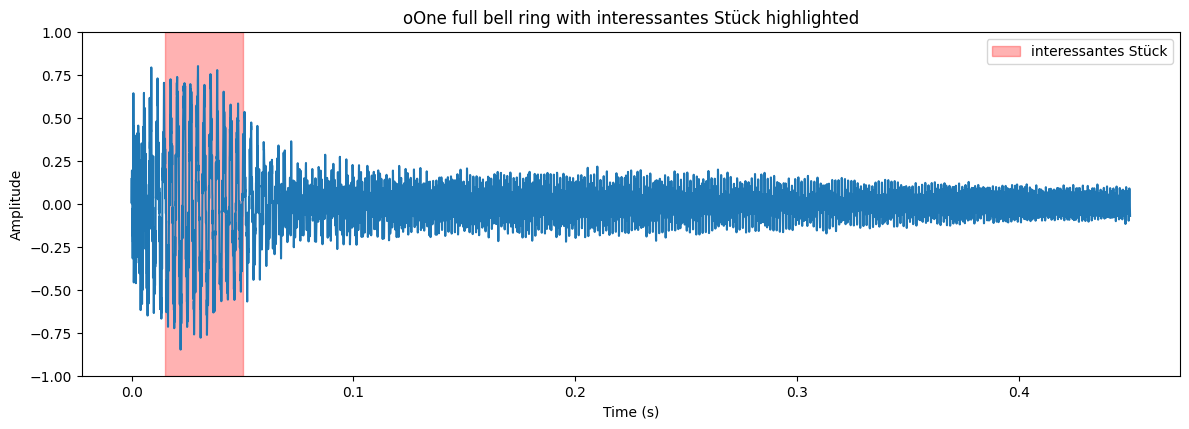

In [8]:
initial_ring_start, initial_ring_end = 0.015, 0.05

initial_ring = signal_hit[int(initial_ring_start * sample_rate):int(initial_ring_end * sample_rate)]

# Stage 2: Zoom Region 1
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(times, signal_hit)
plt.axvspan(initial_ring_start, initial_ring_end, color='red', alpha=0.3, label="interessantes Stück")
plt.title("oOne full bell ring with interessantes Stück highlighted")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()
plt.show()

<h3 id="day-6">6: Finding the Snippet</h3>
Day 6 Task:

Try to find the cut-out piece via cross-correlation in the original signal. How do you recognize that the position fits?

Implementation:

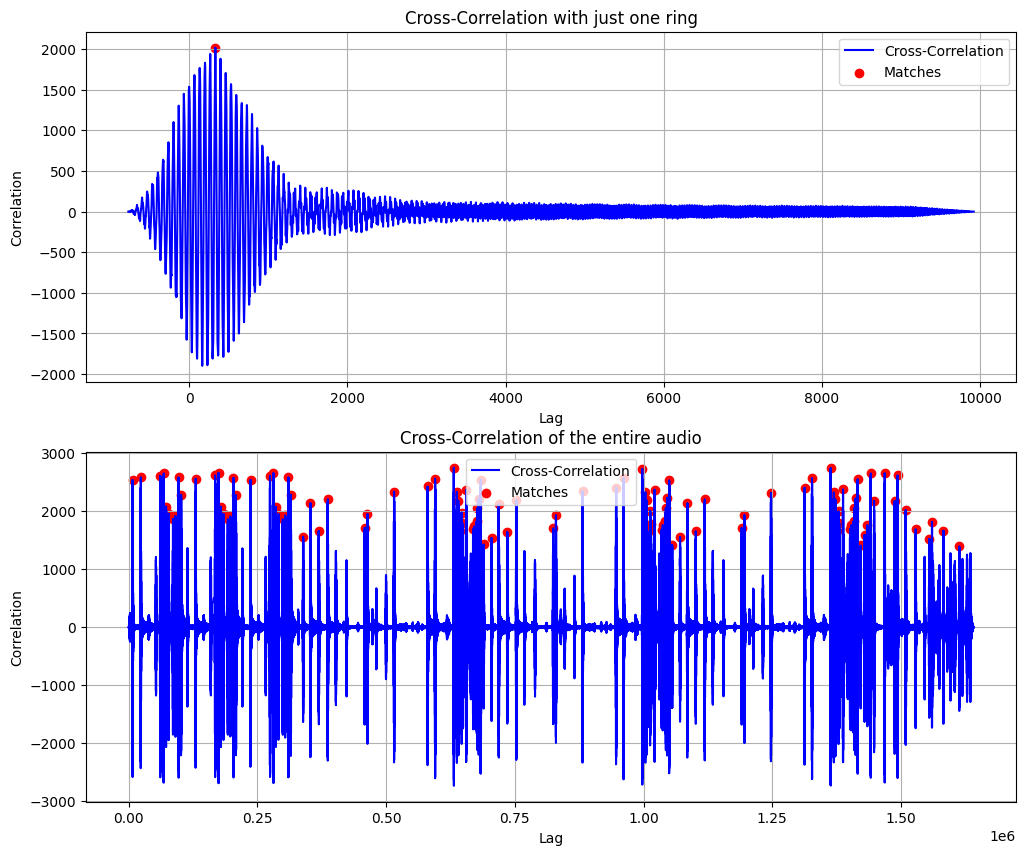

Number of detected matches: 110

In [9]:
audio, sample_rate = librosa.load("sound/bell.wav")

normalized_signal_hit = (signal_hit - np.mean(signal_hit)) / np.std(signal_hit)
normalized_initial_ring = (initial_ring - np.mean(initial_ring)) / np.std(initial_ring)
normalized_audio = (audio - np.mean(audio)) / np.std(audio)

# Compute cross-correlation between the initial ring and a full ring
cross_corr = correlate(normalized_signal_hit, normalized_initial_ring, mode='full')
lags = np.arange(-len(normalized_initial_ring) + 1, len(normalized_signal_hit))
# Find peaks in the cross-correlation
peaks, _ = find_peaks(cross_corr, height=np.max(cross_corr) * 0.5, distance=len(normalized_initial_ring))

#compute the cross-correlation between the full signal and the initial ring
cross_corr_full = correlate(normalized_audio, normalized_initial_ring, mode='full')
lags_full = np.arange(-len(normalized_initial_ring) + 1, len(normalized_audio))
# Find peaks in the cross-correlation
peaks_full, _ = find_peaks(cross_corr_full, height=np.max(cross_corr_full) * 0.5, distance=len(normalized_initial_ring))

# Plot the cross-correlation
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(lags, cross_corr, label="Cross-Correlation", color='blue')
plt.scatter(lags[peaks], cross_corr[peaks], color='red', label="Matches")
plt.title("Cross-Correlation with just one ring")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.legend()
plt.grid()

# Plot the cross-correlation
plt.subplot(2, 1, 2)
plt.plot(lags_full, cross_corr_full, label="Cross-Correlation", color='blue')
plt.scatter(lags_full[peaks_full], cross_corr_full[peaks_full], color='red', label="Matches")
plt.title("Cross-Correlation of the entire audio")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.legend()
plt.grid()
plt.show()

print(f"Number of detected matches: {len(peaks_full)}")


Using cross-correlation, the extracted initial ring segment was successfully identified within both the original single bell ring and the entire audio file containing multiple rings. The cross-correlation function reveals peaks that correspond to the locations where the initial ring pattern matches the larger signals. In the first plot, the initial ring aligns well with the full bell ring, confirming the method's accuracy for small-scale matching. The second plot extends this approach to the entire audio, where 110 matches were detected, demonstrating the robustness of the method in locating recurring patterns over longer recordings. These matches are characterized by high correlation peaks, which verify the alignment between the extracted segment and the signal. 

This method is particularly effective in applications such as acoustic analysis, where detecting and analyzing recurring patterns is critical. Cross-correlation is widely regarded as a powerful tool for signal matching and pattern detection.

Cross-correlation is a measure of similarity between two signals as one signal is shifted relative to the other. In the plot below i try to visualize this, a "heartbeat" signal (red) is compared against a longer "signal" (blue) by sliding the heartbeat across the signal in discrete steps, referred to as shifts. At each shift, the cross-correlation score is calculated by multiplying corresponding values of the two signals and summing the results, as shown in the equations on the right. Positive scores indicate a stronger alignment, while negative scores suggest a mismatch. The process helps identify where and how well the pattern in the smaller signal aligns with the larger signal, making cross-correlation a powerful tool for pattern recognition in time series data.

For further reading, see [What is cross-correlation, and how is it measured?](https://liquidinstruments.com/blog/cross-correlation-and-spectrum-analysis/).

Tomorrow, I will analyze the detected matches with closer visualizations to understand their context and accuracy in more detail.

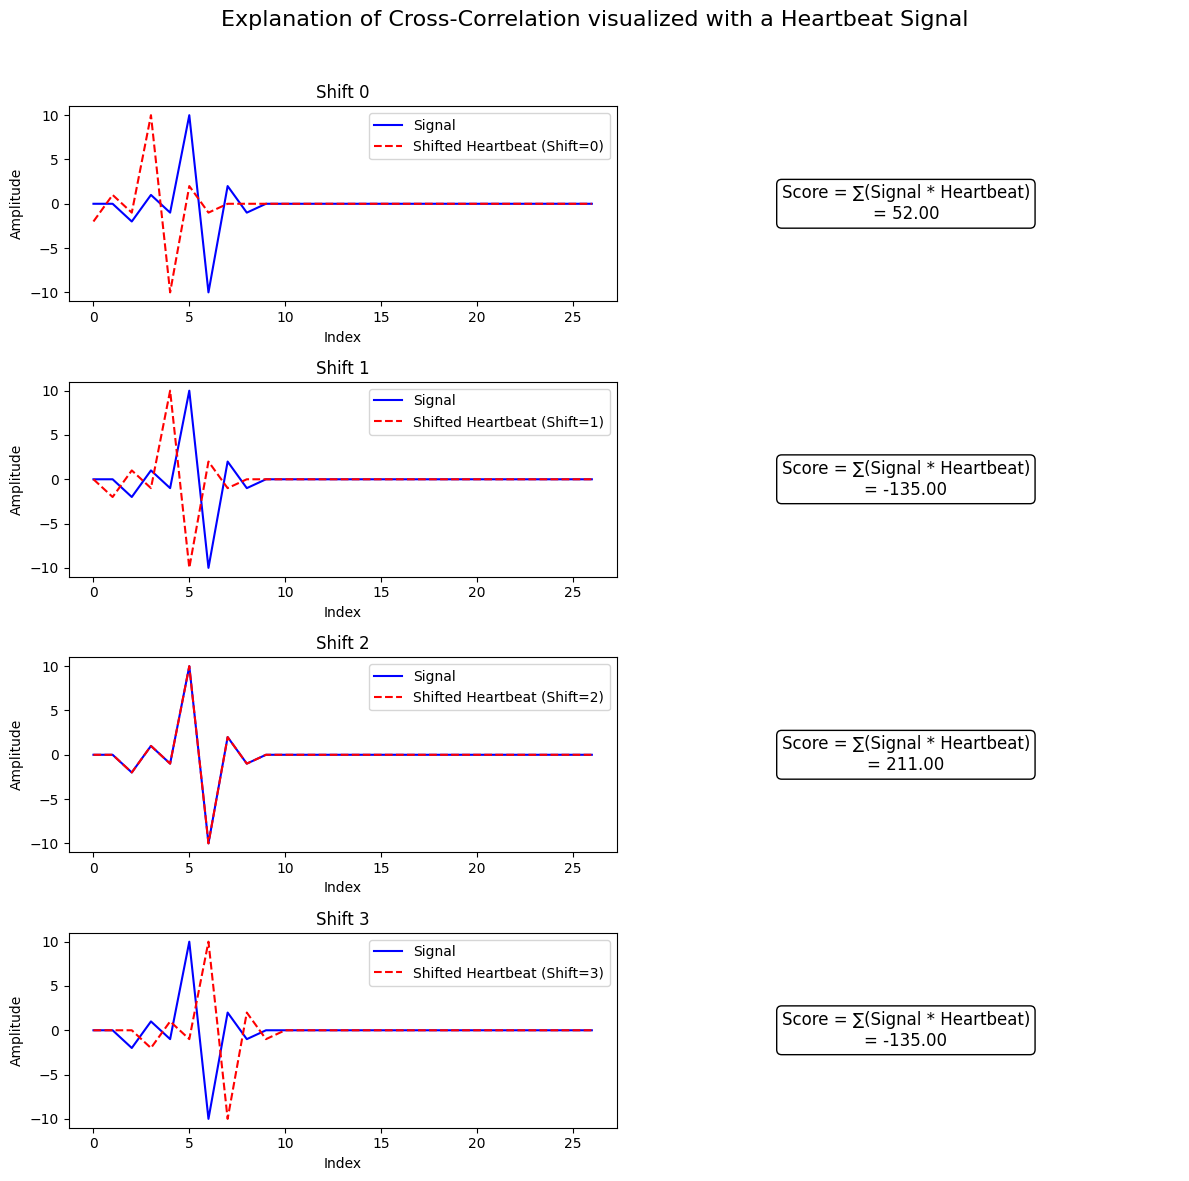

In [10]:
heartbeat = np.array([-2, 1, -1, 10, -10, 2, -1, 0, 0])
long_signal = np.concatenate((np.zeros(2), heartbeat, np.zeros(16)))
num_shifts = 4
signal_len = len(long_signal)
heartbeat_len = len(heartbeat)

fig, axes = plt.subplots(num_shifts, 2, figsize=(12, num_shifts * 3))
fig.suptitle("Explanation of Cross-Correlation visualized with a Heartbeat Signal", fontsize=16)

for i in range(num_shifts):
    shift = i  # Shift the heartbeat by 'i' indices
    
    # Prepare shifted heartbeat
    shifted_heartbeat = np.zeros(signal_len)
    shifted_heartbeat[shift:shift + heartbeat_len] = heartbeat
    
    # Compute the score (dot product) for the current shift
    score = np.dot(long_signal, shifted_heartbeat)
    
    # Plot the signal and shifted heartbeat overlay
    axes[i, 0].plot(long_signal, label="Signal", color="blue")
    axes[i, 0].plot(shifted_heartbeat, label=f"Shifted Heartbeat (Shift={shift})", color="red", linestyle="dashed")
    axes[i, 0].set_title(f"Shift {shift}")
    axes[i, 0].set_xlabel("Index")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].legend()
    
    # Show the score computation explanation
    axes[i, 1].text(0.5, 0.5, f"Score = ∑(Signal * Heartbeat)\n= {score:.2f}", 
                    fontsize=12, ha="center", va="center", bbox=dict(boxstyle="round", facecolor="white"))
    axes[i, 1].axis("off")

plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
plt.show()


<h3 id="day-7">7: Visualizing the Matches</h3>
Day 7 Task:

Visualize the results appropriately. Observe, interpret and discuss in 2-3 sentences.

Implementation:

To visualize the results, one match at random is selected and displayed with its corresponding segment. The full 1-second segment starts 0.1 seconds before the match, and the match itself is highlighted in the plot with a red rectangle to indicate its exact location. Below the full segment plot, the matched segment is directly compared to the original searched snippet, allowing for a visual assessment of their similarity.  

Key Performance Indicators (KPIs) below the plots provide quantitative insights into the matched segment:  
- **SNR (Signal-to-Noise Ratio):** A measure of clarity, calculated by comparing the signal's power to the noise power. A higher SNR indicates that the bell's sound is clear and distinguishable from background noise.  
- **Energy:** Represents the total power of the segment, reflecting the intensity of the bell's sound. Higher energy values correspond to louder or more prominent segments.  
- **PAR (Peak-to-Average Ratio):** Highlights the sharpness of the bell's sound by comparing the maximum peak amplitude to the average signal level. A higher PAR indicates sharper and more distinct peaks.  
- **Correlation:** Quantifies the similarity between the matched segment and the original snippet. A value close to 1 indicates a strong match, verifying the accuracy of the cross-correlation method.  

here some websites i used to find information on the topics:
- <a href="https://resources.pcb.cadence.com/blog/2020-what-is-signal-to-noise-ratio-and-how-to-calculate-it">What is Signal to Noise Ratio and How to calculate it?</a>
- <a href="https://www.everythingrf.com/community/what-is-peak-to-average-power-ratio">What is Peak-To-Average Power Ratio?</a>
- <a href="https://www.allaboutcircuits.com/technical-articles/understanding-correlation/">Understanding Correlation</a>



This enhanced visualization provides both qualitative and quantitative evaluations, effectively showcasing the accuracy and reliability of the cross-correlation results. The combination of visual plots and KPIs ensures the results are clear and relevant to the use case of identifying bell rings in the audio signal.

If the random selection of matches is not functional because you are looking only at the HTML file, you can explore all matches on <a href="https://gbsv.been-jammin.ch/challenge2.html#day-7">this website</a> where i published the notebook.


In [19]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def generate_updated_segment_plots_with_comparison(
    full_audio, audio_sample_rate, found_peaks, lag, sample_to_match, folder ='bell_segments', segment_duration=1.0, pre_peak_time=0.1, num_samples=9995
):
    initial_ring_samples = len(sample_to_match)

    for i in range(min(num_samples, len(found_peaks))):
        peak_idx = found_peaks[i]
        peak_time = lag[peak_idx] / audio_sample_rate

        # Define 1-second segment start and end
        start_time_full = max(0, peak_time - pre_peak_time)
        end_time_full = min(len(full_audio) / audio_sample_rate, start_time_full + segment_duration)
        start_sample_full = int(start_time_full * audio_sample_rate)
        end_sample_full = int(end_time_full * audio_sample_rate)
        audio_segment_full = full_audio[start_sample_full:end_sample_full]

        # Define match start and end
        start_sample_match = max(0, int(peak_time * audio_sample_rate))
        end_sample_match = start_sample_match + initial_ring_samples
        matched_segment = full_audio[start_sample_match:end_sample_match]

        if len(matched_segment) != len(sample_to_match):
            logging.warning(f"Segment {i} skipped due to mismatched length.")
            continue

        # Compute KPIs
        mean = np.mean(matched_segment)
        std_dev = np.std(matched_segment)
        variance = np.var(matched_segment)
        signal_power = np.mean(matched_segment**2)
        noise = matched_segment - sample_to_match
        noise_power = np.mean(noise**2)
        snr = 10 * np.log10(signal_power / noise_power) if noise_power != 0 else np.inf
        rms = np.sqrt(signal_power)
        par = np.max(np.abs(matched_segment)) / rms if rms != 0 else np.inf
        correlation_coeff = np.corrcoef(matched_segment, sample_to_match)[0, 1]

        # Log KPIs
        if i < 1:
            logging.info(f"Segment {i}:")
            logging.info(f"Mean: {mean:.4f}, Std Dev: {std_dev:.4f}, Variance: {variance:.4f}")
            logging.info(f"Signal Power: {signal_power:.4f}, Noise Power: {noise_power:.4f}, SNR: {snr:.2f} dB")
            logging.info(f"RMS: {rms:.4f}, PAR: {par:.2f}, Correlation Coefficient: {correlation_coeff:.4f}")

        # Create time axes
        times_full = np.linspace(start_time_full, end_time_full, len(audio_segment_full))
        times_match = np.linspace(0, len(matched_segment) / audio_sample_rate, len(matched_segment))
        times_original = np.linspace(0, len(sample_to_match) / audio_sample_rate, len(sample_to_match))

        # Plot the full segment and matched segment
        fig = plt.figure(figsize=(15, 6))

        # Top Plot: Full 1-second segment
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(times_full, audio_segment_full, label="Full Segment", color="blue")
        ax1.axvspan(peak_time, peak_time + len(sample_to_match) / audio_sample_rate, color='red', alpha=0.2, label="Match")
        ax1.set_title(f"Match {i}: Full 1-Second Segment")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Amplitude")
        ax1.legend()

        # Bottom Left Plot: Matched segment with original snippet
        ax2 = fig.add_subplot(2, 2, 3)
        ax2.plot(times_original, sample_to_match, label="Original Snippet", color="orange")
        ax2.plot(times_match, matched_segment, label="Matched Segment", color="blue")
        ax2.set_title("Matched vs Original Snippet")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Amplitude")
        ax2.legend()

        # Bottom Right: KPI box
        kpi_text = (
            f"SNR (dB): {snr:.2f} - Clarity of the signal\n"
            f"Energy: {signal_power:.2f} - Total signal strength\n"
            f"PAR: {par:.2f} - Prominence of peaks\n"
            f"Correlation: {correlation_coeff:.4f} - Match similarity"
        )
        ax3 = fig.add_subplot(2, 2, 4)
        ax3.axis("off")
        ax3.text(0.5, 0.5, kpi_text, transform=ax3.transAxes,
                 fontsize=12, va="center", ha="center", bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

        # Save the plot
        plot_file = f"{folder}/segment_plot_{i}.png"
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.close()


In [20]:
generate_updated_segment_plots_with_comparison(audio, sample_rate, peaks_full, lags_full, initial_ring)

2024-12-03 20:41:04,679 - INFO - Segment 0:
2024-12-03 20:41:04,680 - INFO - Mean: -0.0106, Std Dev: 0.4257, Variance: 0.1812
2024-12-03 20:41:04,680 - INFO - Signal Power: 0.1813, Noise Power: 0.0230, SNR: 8.97 dB
2024-12-03 20:41:04,681 - INFO - RMS: 0.4258, PAR: 1.89, Correlation Coefficient: 0.9346


<script>
    function displayRandomSegment() {
        const numSegments = 110; // Total segments available
        const randomIndex = Math.floor(Math.random() * numSegments);

        // Update image and audio dynamically
        document.getElementById("segmentPlot").src = `bell_segments/segment_plot_${randomIndex}.png`;
        document.getElementById("audioPlayer").src = `bell_segments/audio_segment_${randomIndex}.wav`;
        document.getElementById("segmentTitle").innerText = `Currently Showing: Segment ${randomIndex}`;
    }

    window.onload = displayRandomSegment; // Display a random segment on page load
</script>

<div style="text-align: center;">
    <h4>Randomly Selected Segment</h4>
    <img id="segmentPlot" src="" alt="Waveform Plot" style="width:100%; border: 2px solid #ccc; border-radius: 8px;">
    <br><br>
    <audio id="audioPlayer" controls style="width:90%; margin-top: 10px;">
        <source src="" type="audio/wav">
        Your browser does not support the audio element.
    </audio>
    <button onclick="displayRandomSegment()" style="padding: 10px 20px; background-color: #007BFF; color: white; border: none; border-radius: 5px; font-size: 16px; cursor: pointer;">
        See Another Result
    </button>
</div>


### 8: Testing Robustness
Day 8 Task:

What types of changes could you apply to your signal to test whether the cut piece can still be found? Name the 1-2 most important changes that fit your use case. Explain in 1-2 sentences why exactly these changes are relevant.

Implementation:

To test if the extracted bell segment can still be found after transformations, we will apply two changes. First, we will add background noise to test the robustness of the clarity (SNR) KPI, ensuring that the method remains reliable even in noisy environments, such as outdoor recordings or crowded spaces. Second, we will scale the energy of the segment, simulating variations in the strength of the bell hit or the distance of the bell from the recorder. These transformations are directly relevant to the use case, as they represent realistic conditions under which bell recordings might be made, such as varying impact strengths, noisy surroundings, or differing recording setups.

<h3 id="day-9">9: Applying the Transformations</h3>
#### Day 9 Task:

Now alter your cut-out piece accordingly.

#### Implementation:

As background noise i will add random white noise, with a default power of 20% of the signal. 

To simulate the distance i need to know how sound changes at distance:
> For every doubling of distance, the sound level reduces by 6 decibels (dB)
> The sound pressure decreases in inverse proportion to the distance, that is, with 1/r from the measuring point to the sound source, so that doubling of the distance decreases the sound pressure to a half (!) of its initial value - not a quarter.
> Source: [Tontechnik Rechner - sengpielaudio](https://sengpielaudio.com/calculator-SoundAndDistance.htm)



In [21]:
def add_background_noise(signal, noise_level=0.2):
    signal_power = np.mean(np.abs(signal))
    noise_power = abs(signal_power * noise_level)
    noise = np.random.normal(0, noise_power, len(signal))
    return signal + noise

def simulate_distance(signal, original_distance=2, target_distance=5):
    attenuation_factor = (original_distance / target_distance)
    return signal * attenuation_factor

noisy_initial_ring = add_background_noise(initial_ring)
scaled_initial_ring = simulate_distance(initial_ring)
noisy_and_scaled_initial_ring = add_background_noise(scaled_initial_ring)

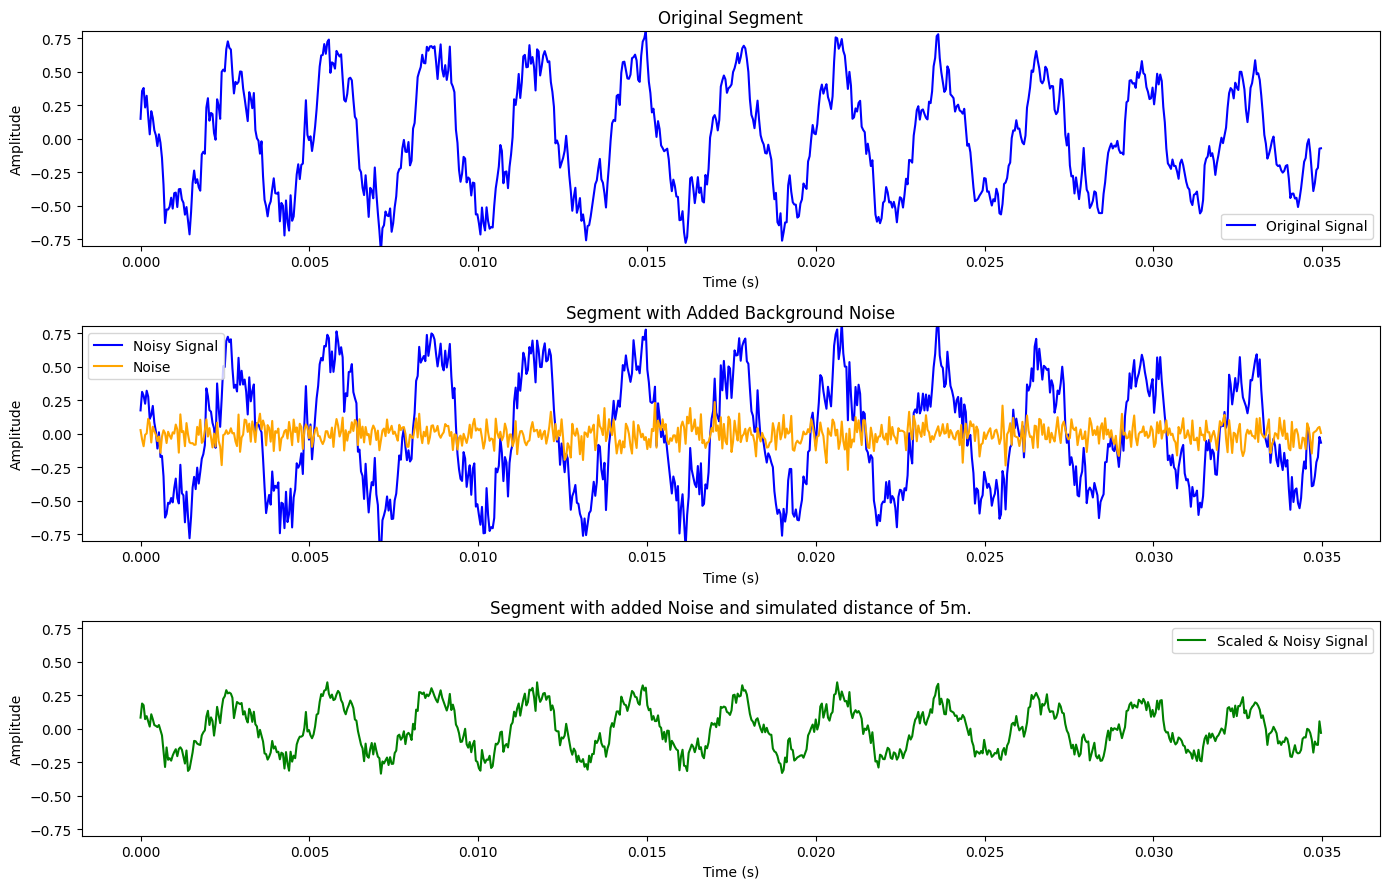

In [22]:
# Time axis for plotting
time_axis = np.arange(len(initial_ring)) / sample_rate

plt.figure(figsize=(14, 9))

# Original Signal
plt.subplot(3, 1, 1)
plt.plot(time_axis, initial_ring, label='Original Signal', color='blue')
plt.title('Original Segment')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-0.8, 0.8)
plt.legend()

# Noisy Signal
plt.subplot(3, 1, 2)
plt.plot(time_axis, noisy_initial_ring, label='Noisy Signal', color='blue')
plt.plot(time_axis, noisy_initial_ring - initial_ring, label='Noise', color='orange')
plt.title('Segment with Added Background Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-0.8, 0.8)
plt.legend()

# Scaled and Noisy Signal
plt.subplot(3, 1, 3)
plt.plot(time_axis, noisy_and_scaled_initial_ring, label='Scaled & Noisy Signal', color='green')
plt.title('Segment with added Noise and simulated distance of 5m.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-0.8, 0.8)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
display(Markdown(f"**original bell sound**"))
display(Audio(signal_hit, rate=sample_rate))

noisy_signal_hit = add_background_noise(signal_hit)
display(Markdown(f"**sound with added noise**"))
display(Audio(noisy_signal_hit, rate=sample_rate))

**original bell sound**

**sound with added noise**

note: to be able to play the sound with added noise i also applied it to a full ring of the bell, otherwise it would have been too short to listen to.

#### Key Performance Indicators (KPIs):

In [27]:
def calculate_kpis(audio_signal, reference=None):
    mean = np.mean(audio_signal)
    std_dev = np.std(audio_signal)
    variance = np.var(audio_signal)
    energy = np.sum(audio_signal ** 2)
    if reference is not None:
        noise = audio_signal - reference
        noise_power = np.mean(noise ** 2)
        snr = 10 * np.log10(np.mean(audio_signal ** 2) / noise_power) if noise_power != 0 else np.inf
        correlation_coeff = np.corrcoef(audio_signal, reference)[0, 1]
    else:
        snr = 10 * np.log10(np.mean(audio_signal ** 2) / np.var(audio_signal))
        correlation_coeff = np.corrcoef(audio_signal, audio_signal)[0, 1]
    par = np.max(np.abs(audio_signal)) / np.mean(np.abs(audio_signal))
    return {
        'Mean': mean,
        'Std Dev': std_dev,
        'Variance': variance,
        'Energy': energy,
        'PAR': par,
        'Correlation': correlation_coeff
    }


kpi_df = pd.DataFrame({
    'Original Signal': calculate_kpis(initial_ring),
    'Noisy Signal': calculate_kpis(noisy_initial_ring, initial_ring),
    'distant & Noisy Signal': calculate_kpis(noisy_and_scaled_initial_ring, initial_ring),
})

print(kpi_df)


Original Signal  Noisy Signal  distant & Noisy Signal
Mean               -0.008270     -0.012667               -0.003830
Std Dev             0.404755      0.411508                0.164854
Variance            0.163827      0.169339                0.027177
Energy            126.527008    130.853620               20.991834
PAR                 2.399498      2.499474                2.418243
Correlation         1.000000      0.984464                0.983747

### 10: Finding altered Snippets
Day 10 Task:

Check whether the piece can still be found via cross-correlation in the modified 1D signal. Visualize the results appropriately. Observe, interpret and discuss in 2-3 sentences.

Implementation:

### Day 11
Welche Arten von Veränderungen werden toleriert? Welche nicht?

In [17]:
sample_rate/328


67.22560975609755

### Day 12 
Diskutiere deine Methoden- und Parameterwahl sowie die Resultate in ca. 150 Wörtern.

## Part 2: Segmentation, Morphological Operations, Object Properties in Images


### Day 13
Passend zu deinem Land: Definiere einen Anwendungsfall, um ähnliche Objekte aus einem einzelnen Bild zu extrahieren bzw. segmentieren, um diese danach möglichst charakteristisch zu vermessen. Suche ein Bild, welches mehrere ähnliche Objekte enthält gemäss deinem Anwendungsfall.

### Day 14
Segmentiere die Objekte mittels geeigneter 1-2 Methoden. Gebe die Resultate als gelabelte Bilder (binär oder pro Klasse 1 Label) aus.

### Day 16
Erkläre für jede angewendete Operation in 1-2 Sätzen, warum du diese Operation anwendest. Beobachte, interpretiere und diskutiere in 2-3 Sätzen.

### Day 17
Überlege dir, mit welchen 2-3 Eigenschaften du die Objekte am charakteristischten vermessen kannst. Extrahiere die einzelnen Objekte, zähle und vermesse die 2-3 Eigenschaften deiner extrahierten Objekte mittels geeigneten Methoden.

### Day 18
Erstelle ein möglichst minimales aber repräsentatives Skeleton eines deiner Objekte und gebe die Anzahl Pixel des Skeletons aus.

### Day 19
Diskutiere deine Methoden- und Parameterwahl, sowie deine Erkenntnisse und Resultate in ca. 150 Wörtern. Sind die Resultate für den Anwendungsfall brauchbar?